Import dependencies

## Teoretiska frågor

### 1. Beskriv kort hur en relationsdatabas fungerar

#### En relationsdatabas är en samling tabeller där varje tabell kan ha en eller flera kolumner och olika antal rader. En kolumn kan ha unika värden på varje rad och då kan dessa användas som en primärnyckel   som kan användas till olika operationer. Tabellerna kan i sin tur ha relationer till andra tabeller genom gemensamma värden (främmande nycklar). På detta sätt skapas en struktur som gör det lättare att sök, uppdatera och analysera datan som finns i tabellerna.

### 2. Vad menas med CRUD-flöder

#### Det är de grundläggande operationer som kan utföras på data i en relationell databas och står för C - create, R - read, U - update, D - delete.

### 3. Beskriv kort vad en "left join" och en "inner join" är. Varför använder man det?

#### Left join - Vid en left join inkluderas all data från den vänstra tabellen och sammanfogas med den data som matchar i den högra tabellen.
#### Inner join - Då sammanfogas två tabeller men endast den data som är lika från de båda tabellerna kommer visas, baserat på ett matchande värde.
#### Joins används för att kombinera data från flera tabeller till en enda tabell och på så sätt få en bättre bild/lättare att senare maipulera datan man vill undersöka.

### 4. Beskriv kort vad indexering i SQL innebär.

#### Indexering är ett sätt att optimera sökningar i databas. Det fungerar lite som en innehållförteckning i en bok och gör att sökningarna går mycket fortare dock med nackdelen att det tar längre tid att skriva/lägga till ny data till en tabell.

### 5. Beskriv kort vad en vy är i SQL.

#### En vy fungerar som en virituell tabell som skapas utifrån en query. Den innehåller inte själva datan utan är en fördefinerad sökning.

### 6. Beskriv kort vad en lagrad procedur i SQL är.

#### En lagrad procedur kan lite jämföras med funktioner i programmering. Lagrade procedurer är en samling förkompilerade satser som utför en specifik uppgift. Några fördelar med en lagrad procedur är t.ex. ökad prestanda, ökad säkerhet och underlättat underhåll då lokigen kan vara samlad på ett och samma ställle.

## Programmeringsuppgift

In [113]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import seaborn.objects as so
import pyodbc
import matplotlib.ticker as ticker
import locale
locale.setlocale(locale.LC_ALL, '') # Ställ in lokala inställningar för att använda tusentalsavskiljare
from sqlalchemy.engine import create_engine, URL
from sqlalchemy import MetaData, Table, inspect
plot = False

Database connection

In [21]:
SERVER = 'localhost'
DATABASE = 'AdventureWorks2022'

connection_string = f"Driver={{ODBC Driver 18 for SQL Server}};Server=localhost;Database=AdventureWorks2022;Trusted_Connection=yes;Encrypt=no"
connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})
engine = create_engine(connection_url)


In [22]:
# Testar kopplingen med ODBC

import pyodbc

conn = pyodbc.connect(
    'Driver={ODBC Driver 18 for SQL Server};'
    'Server=localhost;'
    'Database=AdventureWorks2022;'
    'Trusted_Connection=yes;'
    'Encrypt=no;'
)

print("Anslutningen lyckades!")
conn.close()

Anslutningen lyckades!


### 1. Deskriptiv sammanfattning av databasen AdventureWorks2022

                   ProductName  SubcategoryName CategoryName  ListPrice
0    HL Road Frame - Black, 58      Road Frames   Components    1431.50
1      HL Road Frame - Red, 58      Road Frames   Components    1431.50
2        Sport-100 Helmet, Red          Helmets  Accessories      34.99
3      Sport-100 Helmet, Black          Helmets  Accessories      34.99
4       Mountain Bike Socks, M            Socks     Clothing       9.50
..                         ...              ...          ...        ...
290          ML Bottom Bracket  Bottom Brackets   Components     101.24
291          HL Bottom Bracket  Bottom Brackets   Components     121.49
292         Road-750 Black, 44       Road Bikes        Bikes     539.99
293         Road-750 Black, 48       Road Bikes        Bikes     539.99
294         Road-750 Black, 52       Road Bikes        Bikes     539.99

[295 rows x 4 columns]

 Total antal anställda i företaget är 290 st och de är fördelade på 16 st avdelningar. 

                    De

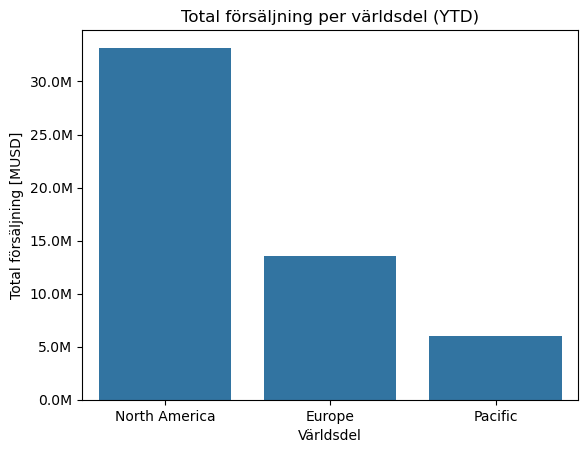

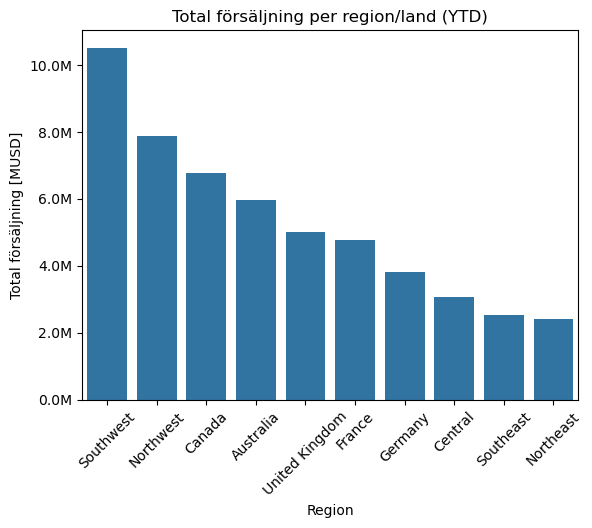

In [81]:
#Listar vilka produkter företaget producerar och säljer.
products_query = """
SELECT 
    p.Name AS ProductName,
    ps.Name AS SubcategoryName,
    pc.Name AS CategoryName,
    p.ListPrice
FROM 
    Production.Product p
JOIN 
    Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
JOIN 
    Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
"""

#Listar till vilka regioner försäljningen har skett.
salesTerritory_query = """
SELECT
    [Name],
    CountryRegionCode,
    [Group],
    SalesYTD
FROM Sales.SalesTerritory
ORDER BY SalesYTD DESC;
"""

#Listar en vy på alla de anställda.
humanResources_query = """
SELECT * FROM HumanResources.vEmployeeDepartment
"""

# Anropar databasen och lagrar resultatet i en DataFrame
with engine.connect() as connection:
    df_products = pd.read_sql(products_query, connection)

with engine.connect() as connection:
    df_SalesTerritory = pd.read_sql(salesTerritory_query, connection)

with engine.connect() as connection:
    df_HumanResources = pd.read_sql(humanResources_query, connection)
    
print(df_products)

#Beräknar antalet anställda i företaget
total_employee = df_HumanResources['BusinessEntityID'].count()
# Antal avdelningar
numberOfDepartments = df_HumanResources['Department'].nunique()

print(f"\n Total antal anställda i företaget är {total_employee} st och de är fördelade på {numberOfDepartments} st avdelningar. \n")

# Gruppera data efter avdelning och räkna antalet
antal_anstallda_per_avdelning = df_HumanResources.groupby('Department').size().reset_index(name='AntalAnställda').sort_values(by='AntalAnställda', ascending=False)

# Visa resultatet
print(antal_anstallda_per_avdelning)

#Summerar den totala försäljningen
total_sales_ytd = df_SalesTerritory['SalesYTD'].sum()

# Avrunda till heltal och formattera med tusentalsavskiljare
formatted_sales = locale.format_string("%d", total_sales_ytd, grouping=True)

print("Total försäljning senaste året:", formatted_sales, "USD")

# Gruppera och summera försäljning per grupp
grouped_sales = df_SalesTerritory.groupby('Group')['SalesYTD'].sum().reset_index().sort_values('SalesYTD', ascending=False)

# Skapa ett stapeldiagram för grupperade data
sns.barplot(x='Group', y='SalesYTD', data=grouped_sales)
plt.title('Total försäljning per världsdel (YTD)')
plt.xlabel('Världsdel')
plt.ylabel('Total försäljning [MUSD]')
# Få tag på den aktuella axeln
ax = plt.gca()
# Anpassa y-axelns formatering
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6}M'))
plt.show()


# Sortera data efter SalesYTD för bättre visualisering
df_SalesTerritory = df_SalesTerritory.sort_values('SalesYTD', ascending=False)

# Skapa ett stapeldiagram
sns.barplot(x='Name', y='SalesYTD', data=df_SalesTerritory)
plt.title('Total försäljning per region/land (YTD)')
plt.xlabel('Region')
plt.ylabel('Total försäljning [MUSD]')
plt.xticks(rotation=45)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6}M'))
plt.show()





#### Detta är ett företag som producerar och säljer cyklar och tillbehör till cyklar. De har senaste året sålt för ca 53 MUSD och de säljer till främts Nord America men även till Europa och Austrialien. Företaget har idagsläget 290 anställda som är fördelade på 16 avdelningar där den absolut största är produktionsavdelningen.

Läser in query från SQL och undersöker Medelsjuktimmar per åldersgrupp

     BusinessEntityID   BirthDate  Age  SickLeaveHours   Department
0                   1  1969-01-29   55              69    Executive
1                   2  1971-08-01   53              20  Engineering
2                   3  1974-11-12   50              21  Engineering
3                   4  1974-12-23   50              80  Tool Design
4                   5  1952-09-27   72              22  Engineering
..                ...         ...  ...             ...          ...
285               286  1977-02-14   47              38        Sales
286               287  1957-09-20   67              30        Sales
287               288  1975-07-09   49              37        Sales
288               289  1968-03-17   56              38        Sales
289               290  1975-09-30   49              37        Sales

[290 rows x 5 columns]
          EmployeeCountInAgeGroup  AverageSickLeaveHours
AgeGroup                                                
30-35                          12             

C:\Users\Dator\AppData\Local\Temp\ipykernel_72932\775772564.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('AgeGroup')


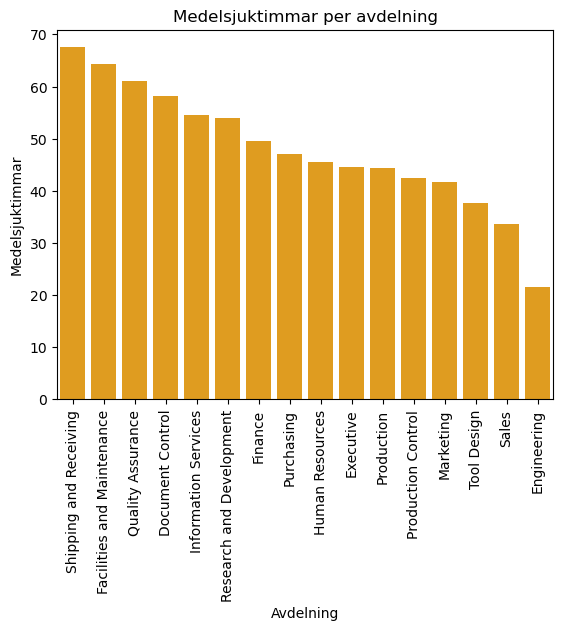

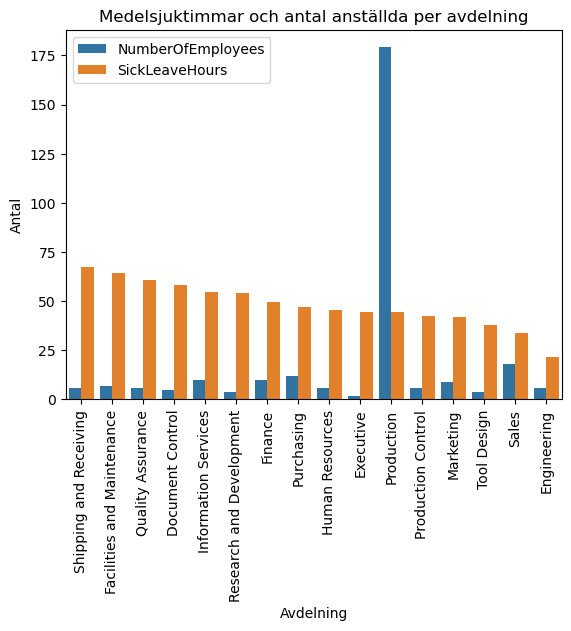

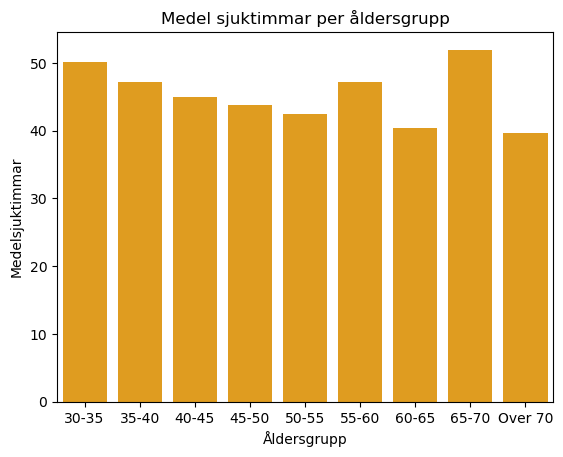

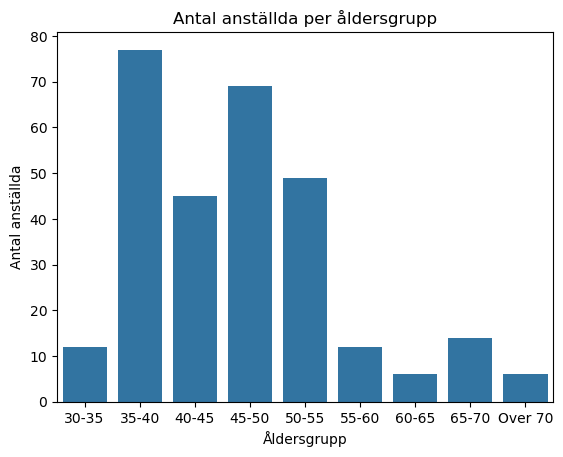

T-test för Engineering vs Shipping and Receiving:
t-statistik: -75.9664997937189
p-värde: 3.814460693590731e-15
Det finns en statistiskt signifikant skillnad i medelvärdet av sjuktimmar mellan avdelningarna Engineering och Shipping and Receiving.
Anställda inom Shipping and Receiving har i genomsnitt fler sjuktimmar.

T-test för 30-35 åringar vs 60-65 åringar
T-statistik: 1.256716655117322
p-värde: 0.226894300461888
Det finns ingen statistiskt signifikant skillnad i medelvärdet av sjuktimmar mellan åldersgrupperna 30-35 och 60-65.


In [120]:
# Här körs en query
query = """

SELECT 
    a.BusinessEntityID,
    a.BirthDate, 
    DATEDIFF(YEAR, BirthDate, GETDATE()) AS Age,
	a.SickLeaveHours,
    b.Department
FROM 
    HumanResources.Employee a
INNER JOIN HumanResources.vEmployeeDepartment b ON a.BusinessEntityID = b.BusinessEntityID

"""

# Anropar databasen och lagrar resultatet i en DataFrame
with engine.connect() as connection:
    df = pd.read_sql(query, connection)

# Visa resultatet
print(df)

#Kategoriserar de anställa i åldersgrupper
bins = [30, 35, 40, 45, 50, 55, 60, 65, 70, np.inf]
labels = ['30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', 'Over 70']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

#Aggregerar data per åldersgrupp
grouped = df.groupby('AgeGroup')
result = grouped.agg({'Age': 'count', 'SickLeaveHours': 'mean'})
result.columns = ['EmployeeCountInAgeGroup', 'AverageSickLeaveHours']
print(result)

# Aggregera data per avdelning och beräkna medelvärdet för sjuktimmar
grouped_department = df.groupby('Department')['SickLeaveHours'].mean().reset_index().sort_values(by='SickLeaveHours', ascending=False)

# Skapa ett stapeldiagram med Seaborn för medelsjuktimmar per avdelning
sns.barplot(x='Department', y='SickLeaveHours', data=grouped_department, color='orange')
plt.title('Medelsjuktimmar per avdelning')
plt.xlabel('Avdelning')
plt.ylabel('Medelsjuktimmar')
plt.xticks(rotation=90)  # Rotera x-axelns etiketter om de är för långa
plt.show()




# Beräkna antal anställda per avdelning
num_employees = df.groupby('Department')['BusinessEntityID'].nunique().reset_index()
num_employees.rename(columns={'BusinessEntityID': 'NumberOfEmployees'}, inplace=True)

# Kombinera dataframes för att kunna visa dem i samma graf.
grouped_department = grouped_department.merge(num_employees, on='Department')

# Skapa ett grupperat stapeldiagram
sns.barplot(x='Department', y='value', hue='variable', data=pd.melt(grouped_department, id_vars=['Department'], value_vars=['NumberOfEmployees', 'SickLeaveHours']))
plt.title('Medelsjuktimmar och antal anställda per avdelning')
plt.xlabel('Avdelning')
plt.ylabel('Antal')
plt.xticks(rotation=90)
plt.legend()
plt.show()



#Medelsjuktimmar per åldersgrupp
sns.barplot(x='AgeGroup', y='AverageSickLeaveHours', data=result, color = "orange")
plt.title('Medel sjuktimmar per åldersgrupp')
plt.xlabel('Åldersgrupp')
plt.ylabel('Medelsjuktimmar')
plt.show()


# Skapa ett stapeldiagram med Seaborn "Antal anställda per åldersgrupp"
sns.barplot(x='AgeGroup', y='EmployeeCountInAgeGroup', data=result)
plt.title('Antal anställda per åldersgrupp')
plt.xlabel('Åldersgrupp')
plt.ylabel('Antal anställda')
plt.show()



#-------STATISTIK-------
# T-test för att jämföra Engineering och Shipping and Receiving
engineering_sick_hours = df[df['Department'] == 'Engineering']['SickLeaveHours']
shipping_sick_hours = df[df['Department'] == 'Shipping and Receiving']['SickLeaveHours']
t_stat, p_value_avdelningar = stats.ttest_ind(engineering_sick_hours, shipping_sick_hours)

#Skriv ut resultat
print("T-test för Engineering vs Shipping and Receiving:")
print("t-statistik:", t_stat)
print("p-värde:", p_value_avdelningar)

# Tolka resultatet för avdelningarna
alpha = 0.05  # Signifikansnivå
if p_value_avdelningar < alpha:
    print("Det finns en statistiskt signifikant skillnad i medelvärdet av sjuktimmar mellan avdelningarna Engineering och Shipping and Receiving.")
    if t_stat > 0:
        print("Anställda inom Engineering har i genomsnitt fler sjuktimmar.")
    else:
        print("Anställda inom Shipping and Receiving har i genomsnitt fler sjuktimmar.")
else:
    print("Det finns ingen statistiskt signifikant skillnad i medelvärdet av sjuktimmar mellan avdelningarna Engineering och Shipping and Receiving.")


# Filtrera data för de två åldersgrupperna
group_30_35 = df[df['AgeGroup'] == '30-35']['SickLeaveHours']
group_60_65 = df[df['AgeGroup'] == '60-65']['SickLeaveHours']

# Utför ett oberoende t-test (antar lika varianser)
t_stat, p_value_aldersgrupper  = stats.ttest_ind(group_30_35, group_60_65)

# Skriv ut resultatet
print("\nT-test för 30-35 åringar vs 60-65 åringar")
print("T-statistik:", t_stat)
print("p-värde:", p_value_aldersgrupper )

# Tolka resultatet
alpha = 0.05  # Signifikansnivå
if p_value_aldersgrupper  < alpha:
    print("Det finns en statistiskt signifikant skillnad i medelvärdet av sjuktimmar mellan åldersgrupperna 30-35 och 60-65.")
else:
    print("Det finns ingen statistiskt signifikant skillnad i medelvärdet av sjuktimmar mellan åldersgrupperna 30-35 och 60-65.")

Sjuktimmar per organisationsnivå och kön

OrganizationLevel
1.0    34.833333
2.0    45.333333
3.0    46.787879
4.0    44.994737
Name: SickLeaveHours, dtype: float64
Gender
F    45.761905
M    45.004878
Name: SickLeaveHours, dtype: float64


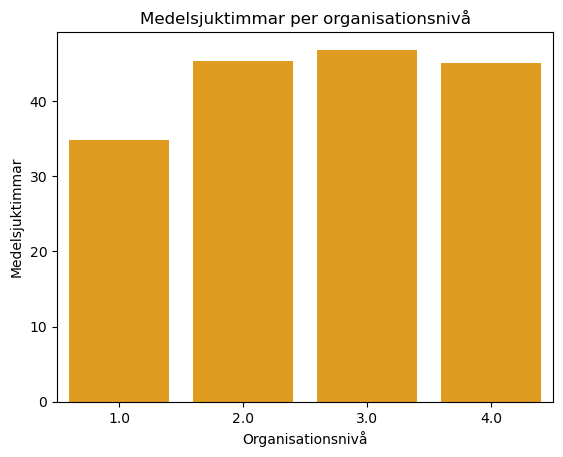

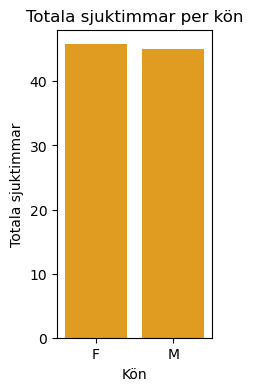

In [111]:
query = """
SELECT 
    OrganizationLevel,
	SickLeaveHours,
    Gender
FROM 
    HumanResources.Employee
"""

# Anropar databasen och lagrar resultatet i en DataFrame
with engine.connect() as connection:
    df = pd.read_sql(query, connection)

# Filtrera för organisationsnivåer 1-4
df_filtered = df[df['OrganizationLevel'].isin([1, 2, 3, 4])]

# Gruppera efter organisationsnivå och beräkna medelvärdet för sjuktimmar
grouped = df_filtered.groupby('OrganizationLevel')
resultOrganizationLevel = grouped['SickLeaveHours'].mean()

# Gruppera efter kön och beräkna totala sjuktimmar
grouped = df_filtered.groupby('Gender')
result = grouped['SickLeaveHours'].mean()

print(resultOrganizationLevel)
print(result)

# Stapeldiagram för medelsjuktimmar per organisationsnivå

sns.barplot(x=resultOrganizationLevel.index, y=resultOrganizationLevel.values, color = "orange")
plt.title('Medelsjuktimmar per organisationsnivå')
plt.xlabel('Organisationsnivå')
plt.ylabel('Medelsjuktimmar')
plt.show()

# Stapeldiagram för totala sjuktimmar per kön
plt.figure(figsize=(2, 4))
sns.barplot(x=result.index, y=result.values, color = "orange")
plt.title('Totala sjuktimmar per kön')
plt.xlabel('Kön')
plt.ylabel('Totala sjuktimmar')
plt.show()